In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision.models import vgg16

In [3]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 加载预训练模型
        self.vgg_model = vgg16(pretrained=True)
        # 改写 预训练模型的部分
        self.classifier = nn.Sequential( nn.Linear(in_features=25088, out_features=100),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.5,inplace=False),
                                        nn.Linear( in_features=100, out_features=6 ),
                                        nn.Sigmoid())
        # 把 预训练模型vgg16的classifier换成我们定义的classifier
        self.vgg_model.classifier = self.classifier
        
        # 冻结vgg模型中的参数
        for param in self.vgg_model.parameters():
            param.requires_grad = False
        
        # 把 classifier中的参数设为可训练
        for param in self.vgg_model.classifier.parameters():
            param.requires_grad = True
    
    def forward(self,input):
        output = self.vgg_model(input)
        
        return output

In [4]:
mymodel = MyModel()

In [5]:
# 可视化模型
from torchsummary import summary
summary(model=mymodel,input_size=[(3,100,100)],batch_size=1,device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 100, 100]           1,792
              ReLU-2          [1, 64, 100, 100]               0
            Conv2d-3          [1, 64, 100, 100]          36,928
              ReLU-4          [1, 64, 100, 100]               0
         MaxPool2d-5            [1, 64, 50, 50]               0
            Conv2d-6           [1, 128, 50, 50]          73,856
              ReLU-7           [1, 128, 50, 50]               0
            Conv2d-8           [1, 128, 50, 50]         147,584
              ReLU-9           [1, 128, 50, 50]               0
        MaxPool2d-10           [1, 128, 25, 25]               0
           Conv2d-11           [1, 256, 25, 25]         295,168
             ReLU-12           [1, 256, 25, 25]               0
           Conv2d-13           [1, 256, 25, 25]         590,080
             ReLU-14           [1, 256,

In [6]:
# 数据集
# 使用 torchvision的 datasets.ImageFolder 类 来导入本地数据集
# 使用 torchvision.transform来进行数据增强
# 训练数据集
train_dataset = torchvision.datasets.ImageFolder(root='D:/dataset/fruit_fresh_rotten/train/',
                                                transform=torchvision.transforms.Compose([
                                                    torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize((100,100)),
                                                    torchvision.transforms.RandomHorizontalFlip(),
                                                    torchvision.transforms.RandomRotation(20),
                                                ]))
# 验证数据集
val_dataset = torchvision.datasets.ImageFolder(root='D:/dataset/fruit_fresh_rotten/test/',
                                                transform=torchvision.transforms.Compose([
                                                    torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize((100,100))
                                                ]))


In [7]:
# 数据导入器
# 训练导入器
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
# 验证导入器
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=64,shuffle=True)

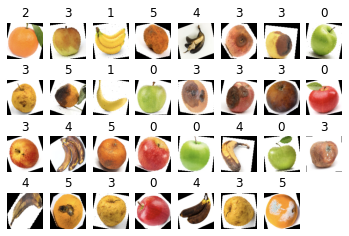

In [8]:
# 可视化 导入器导入的数据
train_iter = iter(train_dataloader)
image,label = train_iter.__next__()
for i in range(31):
    item_image = image[i]
    item_label = label[i]
    item_image = np.transpose(item_image,(1,2,0))
    plt.subplot(4,8,i+1)
    plt.imshow(item_image)
    plt.axis('off')
    plt.title(item_label.item())
plt.show()
plt.close()

In [9]:
# 把数据导入器设置成无限的
def get_infinite_dataloader(dataloader):
    while True:
        for item in dataloader:
            yield item
ifinite_train_dataloader = get_infinite_dataloader(train_dataloader)

In [10]:
# 使用GPU进行训练
# 指定设备
device = torch.device('cuda:0')
# 把模型搬到GPU上
saved_dict = torch.load('mytransferlearning_model.pth')
mymodel.load_state_dict(saved_dict)
mymodel.to(device)

MyModel(
  (vgg_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

In [11]:
# 训练
total_epoch = 1200
optimizer = torch.optim.Adam(mymodel.parameters(),lr=0.0001)

def train():
    mymodel.train()
    # 取数据
    image,label = ifinite_train_dataloader.__next__()
    # 将数据搬到GPU上
    image = image.to(device)
    
    label = label.to(device)
    # 前向传播计算loss
    output = mymodel(image)
    loss = nn.CrossEntropyLoss()(output,label)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 每100轮打印 loss
    if i % 100 == 0 :
        # 计算训练集识别准确率（一个batch）
        _,pred = torch.max(output,1)
        correct_item = (pred==label).sum()
        total_item = len(label)
        total_train_accuracy = correct_item / total_item
        print('epoch:',i,'','loss:',loss.item(),'','total_train_accuracy:',total_train_accuracy.item())

        
def val():
    mymodel.eval()
    total_item = 0
    correct_item = 0
    for item in val_dataloader:
        # 取出数据，搬到GPU上
        image,label = item
        image = image.to(device)
        label = label.to(device)
        # 计算模型输出
        output = mymodel(image)
        # 取出最大的输出作为结果
        _,pred = torch.max(output,1)

        # 更新总预测数量
        total_item += label.size(0)
        # 如果相等，则预测正确数量+1
        correct_item += (pred==label).sum()
    total_val_accuracy = correct_item / total_item
    print('epoch:',i,'','total_val_accuracy:',total_val_accuracy.item())

for i in range(total_epoch+1):
    train()
    if i % 400 == 0 :
        val()
# 模型的保存
torch.save(mymodel.state_dict(),'mytransferlearning_model.pth')


epoch: 0  loss: 1.0564067363739014  total_train_accuracy: 0.984375


KeyboardInterrupt: 